# Fitness Coach Agent with LangGraph

## Overview
An intelligent fitness coaching system built with LangGraph that creates personalized workout plans through conversational interactions with users.

## Key Features

### 🧠 **Long-term Memory**
- **Persistent user profiles** stored across sessions
- **Fitness profile updates** based on user feedback
- **Memory management** using InMemoryStore

### 💬 **Conversational Flow**
- **Multi-turn conversations** with conversation history
- **Clarification questions** to gather complete fitness information
- **Context-aware responses** using previous interactions

### 👥 **Human-in-the-Loop**
- **Workout plan review** with user feedback options
- **Interactive editing** of generated plans
- **Real-time adjustments** based on user preferences

## Architecture

### **Core Components**
- **AssessmentNode**: Evaluates if user profile is complete
- **PlanningNode**: Generates personalized workout plans
- **ReviewNode**: Presents plans for user approval/feedback

### **Data Models**
- **PersonalInfo**: Age, gender, height, weight
- **FitnessProfile**: Level, injuries, goals, exercise frequency
- **WorkoutPlan**: Exercise routines, progression, safety notes

### **Memory System**
- **Short-term**: Conversation history via MemorySaver
- **Long-term**: User profiles via InMemoryStore
- **Profile updates**: Selective updates based on new information

## Workflow
1. **User provides initial info** → Assessment checks completeness
2. **Missing info** → Clarification questions asked
3. **Complete profile** → Personalized workout plan generated
4. **Plan review** → User accepts/edits/provides feedback
5. **Profile updates** → Long-term memory updated with new info

## Technology Stack
- **LangGraph**: Workflow orchestration and state management
- **LangChain**: LLM integration and structured output
- **Pydantic**: Data validation and serialization

This creates a comprehensive fitness coaching experience that learns and adapts to each user's needs over time.

In [10]:
from typing import TypedDict, List, Dict, Literal, Optional
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState

class PersonalInfo(BaseModel):
    age: int = 25  # Simple default value
    gender: Literal["male", "female"] = "male"  # Default to male
    height: int = Field(default=170, description="Height in centimeters")  # Using Field with description
    weight: int = Field(default=70, ge=1, le=500, description="Weight in kilograms")  # With validation

class FitnessProfile(BaseModel):
    personal_info: PersonalInfo
    fitness_level: Literal["beginner", "intermediate", "advanced"]
    injuries: Optional[List[Dict[str, str]]]  # {"injury": "knee pain", "date": "2024-01", "status": "recovering"}
    medical_conditions: Optional[List[str]]
    current_exercise_frequency: Literal["1-2 times per week", "3-4 times per week", "5-6 times per week", "7+ times per week"]
    goals: List[str]  # Multiple goals allowed
 
class WorkoutPlan(BaseModel):
    workout_plan: str = Field("Exercise routine with sets/reps")
    progression: str = Field("How to progress safely over time")
    safety_notes: str = Field("Important safety considerations")
    general_wellness: str = Field("Basic wellness tips - consult professionals for specific advice")

class OverallState(MessagesState):
    fitness_profile: FitnessProfile
    workout_plan: WorkoutPlan
    
class ClarifyWithUser(BaseModel):
    """Schema for user clarification decision."""
    
    need_clarification: bool = Field(
        description="Whether the user needs to be asked clarifying questions.",
    )
    reasoning: str = Field(
        description="Reason behind your decision."
    )
    clarification_questions: List[str] = Field(
        description="A list of questions to ask the user to clarify their fitness profile."
    )
    fitness_profile: FitnessProfile = Field(
        description="The fitness profile of the user."
    )
    verification:str = Field(
        description="Verify message that we will start planning after the user has provided the necessary information.",
    )

In [ ]:
CLARIFY_DECISION_PROMPT = """
Given the user's fitness profile:
{user_profile}

And the messages that have been exchanged so far for building the fitness profile:
<Messages>
{messages}
</Messages>

Assess whether you need to ask a clarifying question, or if the user has already provided enough information for you to start research.
IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.

REQUIRED FIELDS:
1. personal_info: Basic information about the user (age, gender, height, weight)
2. fitness_level: Must be one of "beginner", "intermediate", or "advanced"
3. health_status: Including:
   - injuries: Any current or past injuries that might affect workouts
   - medical_conditions: Any medical conditions that impact exercise
4. preferences: Including:
   - current_exercise_frequency: How often they work out ("1-2 times per week", "3-4 times per week", "5-6 times per week", "7+ times per week")
   - goals: Their fitness goals (e.g., weight loss, muscle gain, endurance, etc.)

ASSESSMENT CRITERIA:
- If ANY of the required fields are missing, incomplete, or unclear, you MUST ask for clarification

Return your assessment using the ClarifyWithUser schema:
- need_clarification: true if any required information is missing
- reasoning: Explain specifically what information is missing or unclear

Only set need_clarification to false if you have ALL the information needed to create a complete, actionable fitness plan.
"""

FITNESS_PROFILE_UPDATE_INSTRUCTIONS = """
# Role and Objective
You are a fitness profile manager for a fitness coach agent that selectively updates user fitness profiles based on new information provided by users during conversations.

# Instructions
- NEVER overwrite the entire fitness profile
- ONLY make targeted additions of new information
- ONLY update specific facts that are directly provided or corrected by the user
- PRESERVE all other existing information in the profile
- Format the profile consistently with the original structure
- Generate the profile as a structured FitnessProfile object

# Reasoning Steps
1. Analyze the current fitness profile structure and content
2. Review new user messages for additional fitness information
3. Extract relevant fitness data from these messages (such as new goals, updated exercise frequency, injury status changes, medical conditions, etc.)
4. Compare new information against existing profile
5. Identify only specific facts to add or update
6. Preserve all other existing information
7. Output the complete updated FitnessProfile

# Example
<current_profile>
Personal Info: Age: 25, Gender: male, Height: 170cm, Weight: 70kg
Fitness Level: beginner
Injuries: None
Medical Conditions: None
Exercise Frequency: 3-4 times per week
Goals: ["lose weight", "gain muscle"]
</current_profile>

<user_messages>
"I've been working out for 6 months now, so I'm more intermediate level. Also, I have a knee injury from last month."
</user_messages>

<updated_profile>
Personal Info: Age: 25, Gender: male, Height: 170cm, Weight: 70kg
Fitness Level: intermediate
Injuries: [{{"injury": "knee injury", "date": "last month", "status": "recovering"}}]
Medical Conditions: None
Exercise Frequency: 3-4 times per week
Goals: ["lose weight", "gain muscle"]
</updated_profile>

# Process current profile:
<current_profile>
{current_profile}
</current_profile>

Think step by step about what specific fitness information is being provided and what specific details should be added or updated in the profile while preserving everything else.

Think carefully and update the fitness profile based upon these user messages:"""

PLANNING_PROMPT = """
You are a fitness coach.

Given this user's fitness profile:
{fitness_profile}

first update the user's fitness profile to long term memory using the save_fitness_profile tool.

Then, generate a workout plan, progression, safety notes, and general wellness tips for the user.
"""

# Updating memory

In [ ]:
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig

# Write to Long term memory using tool
def save_fitness_profile(store: BaseStore, fitness_profile: FitnessProfile, config: RunnableConfig) -> str: 
    """Save user info.""" 
    user_id = config["configurable"].get("user_id")
    store.put(("users", "fitness_profile"), user_id, fitness_profile) 
    print("Successfully updated fitness profile.")

# To do: update this to only update necessary parts of the profile or plan
def update_fitness_profile(store: BaseStore, fitness_profile: FitnessProfile, config: RunnableConfig, messages) -> str: 
    """Update fitness profile based on user messages.""" 
    llm_with_structured_output = llm.with_structured_output(FitnessProfile)
    llm_with_structured_output.invoke(
        [ {"role": "system", "content": FITNESS_PROFILE_UPDATE_INSTRUCTIONS.format(current_profile=fitness_profile)}
            ] + messages
    )
    #print("user_id:\n", user_id)
    save_fitness_profile(store, fitness_profile, config) 
    return "Successfully updated fitness profile."

# get fitness profile from long term memory
def get_fitness_profile(store: BaseStore, config: RunnableConfig) -> FitnessProfile:
    user_id = config["configurable"].get("user_id")
    return store.get(("users","fitness_profile"), user_id)


# Formating

In [ ]:

def format_clarification_questions(questions_list):
    """
    Format a list of clarification questions into a user-friendly string.
    
    Args:
        questions_list: List of questions or a single question string
    
    Returns:
        str: Nicely formatted questions string
    """
    if isinstance(questions_list, str):
        # If it's already a string, return as is
        return questions_list
    
    if isinstance(questions_list, list) and len(questions_list) > 0:
        # Format as numbered list
        formatted_questions = "I need a bit more information to create your personalized fitness plan. Please help me with the following:\n\n"
        
        for i, question in enumerate(questions_list, 1):
            formatted_questions += f"{i}. {question}\n"
        
        formatted_questions += "\nPlease provide all the information above so I can create the best fitness plan for you! 💪"
        return formatted_questions
    
    return "I need some additional information to help you better."


def format_workout_plan(workout_plan: WorkoutPlan):
# Format the workout plan for the user to see
    user_friendly_plan = f"""
🎯 **Your Personalized Fitness Plan**

**Workout Plan:**
{workout_plan.workout_plan}

**Progression Strategy:**
{workout_plan.progression}

**Safety Notes:**
⚠️ {workout_plan.safety_notes}

**General Wellness Tips:**
💡 {workout_plan.general_wellness}

Good luck with your fitness journey! 💪
"""
    return user_friendly_plan

# Complete Graph

In [ ]:
from langgraph.types import interrupt, Command
import uuid
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.store.memory import InMemoryStore
llm = init_chat_model(model="openai:gpt-4o-mini")


def AssessmentNode(state: OverallState, store: BaseStore, config: RunnableConfig) -> Command[Literal["__end__", "planning"]]:
    # try to get user profile from store 
    user_id = config["configurable"]["user_id"]

    existing_user_profile = store.get(("users","fitness_profile"), user_id)
    
    print(f"Existing user profile: {existing_user_profile or 'No profile found (first time user)'}")
    
    llm_with_structured_output = llm.with_structured_output(ClarifyWithUser)
    # let llm assess whether more information is needed 
    clarify_decision = llm_with_structured_output.invoke(
        [HumanMessage(content=CLARIFY_DECISION_PROMPT.format(user_profile=existing_user_profile, messages=get_buffer_string(state["messages"])))]
    )
    
    # print("messages:\n", state["messages"])
    # print("clarify_decision.reasoning:", clarify_decision.reasoning)
    if clarify_decision.need_clarification:
        return Command(
            goto=END,
            update={"messages": [
                AIMessage(content=format_clarification_questions(clarify_decision.clarification_questions))
            ] 
            }
        )
    else: # no need to ask for clarification
        print("========== No clarification needed ==========")
        # save fitness profile to long term memory
        update_fitness_profile(store, clarify_decision.fitness_profile, config, state["messages"])
        # go to planning node
        return Command(
            goto="planning",
            update={
                "messages": [
                    AIMessage(content=clarify_decision.verification),
                    ],
                "fitness_profile": clarify_decision.fitness_profile
            }
        )

def planning_node(state: OverallState, store: BaseStore, config: RunnableConfig):
    print("========== planning_node ==========")
    
    # get fitness profile from long term memory
    fitness_profile = get_fitness_profile(store, config)
    llm_with_structured_output = llm.with_structured_output(WorkoutPlan)

    workout_plan = llm_with_structured_output.invoke(
        [ {"role": "system", "content": PLANNING_PROMPT.format(fitness_profile=fitness_profile)}]
        + state["messages"] 
    )

    return {
        "workout_plan": workout_plan,
        # User-visible message (what the user sees)
        "messages": [AIMessage(content=format_workout_plan(workout_plan))]
    }

def review_workout_plan(state: OverallState, store: BaseStore, config: RunnableConfig):
    print("========== review_workout_plan ==========")
    
    user_friendly_plan = format_workout_plan(state["workout_plan"])
    # Create messages
    messages = [{"role": "user",
                "content": f"Workout plan to be reviewed: {user_friendly_plan}"
                }]
    
    # create interrupt to show to user
    request = {
        "action_request": {
            "action": "Please review the workout plan. You have the option to accept, edit, or ignore the plan.",
            "args": {}
        },
        "config": {
            "allow_ignore": True,  
            "allow_respond": True, 
            "allow_edit": False, 
            "allow_accept": True,  
        },
        # Email to show in Agent Inbox
        "description": user_friendly_plan,
    }
    
    # Agent Inbox responds with a list of dicts with a single key `type` that can be `accept`, `edit`, `ignore`, or `response`.  
    response = interrupt([request])[0]

    # If user provides feedback, go to response agent and use feedback to respond to email   
    if response["type"] == "response":
        # Add feedback to messages 
        user_input = response["args"]
        # Used by the response agent
        messages.append({"role": "user",
                        "content": f"User provide feedback to modify the workout plan. Use this feedback: {user_input}"
                        })
        # UPDATE FITNESS PROFILE IF NEEDED
        update_fitness_profile(store, state["fitness_profile"], config, messages)
        # Go to planning node to generate new workout plan
        goto = "planning"
    
    elif response["type"] == "accept" or response["type"] == "ignore":
        # Save workout plan to long term memory
        user_id = config["configurable"].get("user_id")
        store.put(("users", "workout_plan"), user_id, state["workout_plan"]) 
        # Go to END
        goto = END

    else:
        raise ValueError(f"Invalid response type: {response['type']}")    
    
    # Update the state 
    update = {
        "messages": messages,
    }

    return Command(goto=goto, update=update)


    
from langgraph.checkpoint.memory import MemorySaver

store = InMemoryStore()
checkpointer = MemorySaver()  # Add checkpointer for conversation history
graph = StateGraph(OverallState)

graph.add_node("assessment", AssessmentNode)
graph.add_node("planning", planning_node)
graph.add_node("review_workout_plan", review_workout_plan)

graph.add_edge(START, "assessment")
graph.add_edge("planning", "review_workout_plan")
graph.add_edge("review_workout_plan", END)

compiled_graph = graph.compile(store=store, checkpointer=checkpointer)

# Diagram

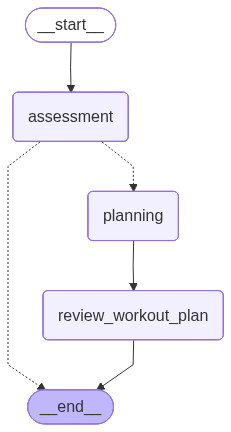

In [13]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

# Execute workflow

## Clarifying --> Planning --> Review

In [14]:
print("\n" + "="*50 + "\n")
# Correct way to handle continuous conversation
config = {
    "configurable": {
        "thread_id": "1",
        "user_id": "1"
    }
}
for chunk in compiled_graph.stream(
    {"messages": [{"role": "user", "content": "I'm henry 25 year old, 170cm tall and 70kg."}]},
    config,  # Same config to continue the thread
    #stream_mode="values" #default is values
):  
    for node_name, update_data in chunk.items():
        if 'messages' in update_data:
            print(f"From {node_name}: {update_data['messages'][-1].pretty_print()}")
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")




Existing user profile: No profile found (first time user)
================================== Ai Message ==================================

I need a bit more information to create your personalized fitness plan. Please help me with the following:

1. What is your gender?
2. How would you rate your fitness level (beginner, intermediate, advanced)?
3. How often do you currently exercise (1-2 times per week, 3-4 times per week, 5-6 times per week, 7+ times per week)?
4. What are your fitness goals (e.g., weight loss, muscle gain, endurance)?
5. Do you have any current or past injuries that could affect your workouts?
6. Do you have any medical conditions that impact your ability to exercise?

Please provide all the information above so I can create the best fitness plan for you! 💪
From assessment: None


In [16]:

for chunk in compiled_graph.stream(
    {"messages": [{"role": "user", "content": "I'm beginner level, I want to lose weight and gain muscle, I have no injuries and no medical conditions. I work out 3-4 times per week. I'm male."}]},
    config,  # Same config to continue the thread
    stream_mode="updates"
):  
    for node_name, update_data in chunk.items():
        if 'messages' in update_data:
            print(f"From {node_name}: {update_data['messages'][-1].pretty_print()}")
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")



Existing user profile: Item(namespace=['users', 'fitness_profile'], key='1', value=FitnessProfile(personal_info=PersonalInfo(age=25, gender='male', height=170, weight=70), fitness_level='beginner', injuries=None, medical_conditions=None, current_exercise_frequency='3-4 times per week', goals=['lose weight', 'gain muscle']), created_at='2025-09-17T06:04:30.338114+00:00', updated_at='2025-09-17T06:04:30.338115+00:00')
========== No clarification needed ==========
Successfully updated fitness profile.
================================== Ai Message ==================================

We can now proceed with creating your personalized fitness program based on the provided information!
From assessment: None
========== planning_node ==========
================================== Ai Message ==================================


🎯 **Your Personalized Fitness Plan**

**Workout Plan:**
### Workout Plan for Henry

**Weekly Structure:** 3-4 workout sessions per week. Each session focuses on strength t

## Resume

In [17]:
for chunk in compiled_graph.stream(Command(resume=[{"type": "response", "args": {"args": "Adjust the plan to focus more on abs"}}]), 
config=config,
stream_mode="values"
):
    # Inspect response_agent most recent message
    if 'messages' in chunk and chunk['messages']:
        print(chunk["messages"][-1].pretty_print())
        # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

================================== Ai Message ==================================


🎯 **Your Personalized Fitness Plan**

**Workout Plan:**
### Workout Plan for Henry

**Weekly Structure:** 3-4 workout sessions per week. Each session focuses on strength training to build muscle and cardio for weight loss.

---

#### Day 1: Upper Body Strength
1. **Warm-up (10 minutes):** Light cardio (jogging or cycling)
2. **Exercises:**  
   - Push-ups: 3 sets of 8-12 reps  
   - Dumbbell Bench Press: 3 sets of 8-12 reps  
   - Bent-over Dumbbell Rows: 3 sets of 8-12 reps  
   - Dumbbell Shoulder Press: 3 sets of 8-12 reps  
   - Plank: 3 sets for 30 seconds to 1 minute  
3. **Cool Down (5-10 minutes):** Stretching for upper body  

---

#### Day 2: Lower Body Strength
1. **Warm-up (10 minutes):** Light cardio (jogging or cycling)
2. **Exercises:**  
   - Bodyweight Squats: 3 sets of 10-15 reps  
   - Lunges: 3 sets of 10-12 reps per leg  
   - Dumbbell Deadlifts: 3 sets of 10-12 reps  
   - Leg Press

In [18]:
for chunk in compiled_graph.stream(Command(resume=[{"type": "accept", "args": "ok"}]), config=config):
    # Inspect response_agent most recent message
    if 'messages' in chunk and chunk['messages']:
        print(chunk["messages"][-1].pretty_print())
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

========== review_workout_plan ==========


# Inspect state

In [19]:
state = compiled_graph.get_state(config)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

I'm henry 25 year old, 170cm tall and 70kg.
================================== Ai Message ==================================

I need a bit more information to create your personalized fitness plan. Please help me with the following:

1. What is your gender?
2. How would you rate your fitness level (beginner, intermediate, advanced)?
3. How often do you currently exercise (1-2 times per week, 3-4 times per week, 5-6 times per week, 7+ times per week)?
4. What are your fitness goals (e.g., weight loss, muscle gain, endurance)?
5. Do you have any current or past injuries that could affect your workouts?
6. Do you have any medical conditions that impact your ability to exercise?

Please provide all the information above so I can create the best fitness plan for you! 💪
================================ Human Message =================================

I'm beginner level, I want to lose weight and gain muscle, I 

In [20]:
result = compiled_graph.get_state(config).values
print(result)

{'messages': [HumanMessage(content="I'm henry 25 year old, 170cm tall and 70kg.", additional_kwargs={}, response_metadata={}, id='8087218c-8fbe-4809-adae-aafaf9156181'), AIMessage(content='I need a bit more information to create your personalized fitness plan. Please help me with the following:\n\n1. What is your gender?\n2. How would you rate your fitness level (beginner, intermediate, advanced)?\n3. How often do you currently exercise (1-2 times per week, 3-4 times per week, 5-6 times per week, 7+ times per week)?\n4. What are your fitness goals (e.g., weight loss, muscle gain, endurance)?\n5. Do you have any current or past injuries that could affect your workouts?\n6. Do you have any medical conditions that impact your ability to exercise?\n\nPlease provide all the information above so I can create the best fitness plan for you! 💪', additional_kwargs={}, response_metadata={}, id='69fb0f41-c93c-438d-99e7-f5014c590933'), HumanMessage(content="I'm beginner level, I want to lose weight

In [ ]:
print(result['fitness_profile'])

personal_info=PersonalInfo(age=25, gender='male', height=170, weight=70) fitness_level='beginner' injuries=None medical_conditions=None current_exercise_frequency='3-4 times per week' goals=['lose weight', 'gain muscle']


In [11]:
print(result['workout_plan'])

workout_plan='🎯 **Your Personalized Fitness Plan (Revised)**\n\n**Workout Plan for Henry (Beginner Level)**\n\n**Weekly Schedule:** \n- **Day 1: Lower Body Strength Training**  \n 1. Bodyweight Squats: 4 sets of 10-12 reps  \n 2. Lunges (Forward or Reverse): 3 sets of 10 reps per leg  \n 3. Glute Bridges: 4 sets of 12-15 reps  \n 4. Calf Raises: 3 sets of 12-15 reps  \n 5. Side Leg Raises: 3 sets of 10-12 reps per side  \n\n- **Day 2: Cardio & Core**  \n 1. 20-30 min brisk walking, jogging, or cycling  \n 2. Plank: 3 sets of 20-30 seconds  \n 3. Bicycle Crunches: 3 sets of 15 reps  \n\n- **Day 3: Rest or Active Recovery** (light stretching or walking)  \n\n- **Day 4: Lower Body Strength Training** (Same as Day 1)  \n\n- **Day 5: HIIT (High Intensity Interval Training)**  \n 1. 20 seconds of jump squats (alternate with 40 seconds of rest, 10 rounds)  \n 2. 20 seconds of mountain climbers (alternate with 40 seconds of rest, 10 rounds)  \n\n- **Day 6: Cardio or Group Class** (yoga, cyclin

In [12]:
print(result['workout_plan'].progression)
print(result['workout_plan'].safety_notes)
print(result['workout_plan'].general_wellness)


**Progression Plan**  
1. **Increase Reps:** Start with the recommended reps and increase by 1-2 each week as you feel stronger.  
2. **Add Weight:** After 3-4 weeks, consider using a backpack with weights or dumbbells for squats and lunges.  
3. **Increase Cardio Duration:** Gradually increase your cardio sessions by 5 minutes each week until you reach 45-60 minutes.  
4. **Focus on Lower Body Strength:** Aim to continue to progress by adding more sets or reps specifically to lower body workouts throughout the plan.
⚠️ **Safety Notes**  
1. Always warm up before starting your workouts (5-10 minutes of light cardio) and cool down/stretch afterward to prevent injuries.  
2. Listen to your body: If you experience pain (not just discomfort), stop the exercise.  
3. Stay hydrated before, during, and after workouts.  
4. Consider consulting a fitness professional to learn proper form for exercises, especially since you're a beginner.
💡 **General Wellness Tips**  
1. Aim to get at least 7-8 

In [21]:
# check workout plan in long term memory
user_id = config["configurable"].get("user_id")
workout_plan = store.get(("users", "workout_plan"), user_id)
print(workout_plan)

Item(namespace=['users', 'workout_plan'], key='1', value=WorkoutPlan(workout_plan='🎯 **Your Updated Personalized Fitness Plan**\n\n**Workout Plan:**\n### Workout Plan for Henry\n\n**Weekly Structure:** 3-4 workout sessions per week. Each session maintains a balance of strength training, cardio for weight loss, and increased focus on abdominal exercises.\n\n---\n\n#### Day 1: Upper Body Strength + Core Focus\n1. **Warm-up (10 minutes):** Light cardio (jogging or cycling)\n2. **Exercises:**  \n   - Push-ups: 3 sets of 8-12 reps  \n   - Dumbbell Bench Press: 3 sets of 8-12 reps  \n   - Bent-over Dumbbell Rows: 3 sets of 8-12 reps  \n   - Dumbbell Shoulder Press: 3 sets of 8-12 reps  \n   - Plank: 3 sets for 30 seconds to 1 minute  \n   - **Abdominal Crunches:** 3 sets of 15-20 reps  \n3. **Cool Down (5-10 minutes):** Stretching for upper body  \n\n---  \n\n#### Day 2: Lower Body Strength + Core Focus\n1. **Warm-up (10 minutes):** Light cardio (jogging or cycling)\n2. **Exercises:**  \n   